# Object Tracking

We can, of course, perform colour segmentation or even object detection (using the Cascade Classifier) on every frame of the video. But unfortunately in this case our computer vision algorithms will not be able to make the logical leap and understand, that the object detected in frame $i$ and the object detected in frame $i+1$ are actually **the same object**.

No to mention, running object detection algorithms like the Cascade Classifier on every frame of the video is very unefficient.

That is why we need tracking algorithms. A tracking algorithm is an algorithm that links together the object (track window) in frame $i$ and frame $i+1$, tracking its motion.

There are many tracking algorithms that exist, and also many approaches to the tracking itself, which include:
1. **Dense Optical flow**: These algorithms help estimate the motion vector of every pixel in a video frame.
2. **Sparse optical flow**: These algorithms, like the Kanade-Lucas-Tomashi (KLT) feature tracker, track the location of a few feature points in an image.
3. **Kalman Filtering&&: A very popular signal processing algorithm used to predict the location of a moving object based on prior motion information. One of the early applications of this algorithm was missile guidance! Also as mentioned here, “the on-board computer that guided the descent of the Apollo 11 lunar module to the moon had a Kalman filter”.
4. **Meanshift and Camshift**: These are algorithms for locating the maxima of a density function. They are also used for tracking.
5. **Single object trackers**: In this class of trackers, the first frame is marked using a rectangle to indicate the location of the object we want to track. The object is then tracked in subsequent frames using the tracking algorithm. In most real life applications, these trackers are used in conjunction with an object detector.
6. **Multiple object track finding algorithms**: In cases when we have a fast object detector, it makes sense to detect multiple objects in each frame and then run a track finding algorithm that identifies which rectangle in one frame corresponds to a rectangle in the next frame.

In this lecture we will discuss several of these approaches, including Optical Flow, MeanShift/Camshift and some of the others.

## Optical Flow

Optical flow is the pattern of apparent motion of image objects between two consecutive frames caused by the movemement of object or camera. It is 2D vector field where each vector is a displacement vector showing the movement of points from first frame to second. Consider the image below
![](https://docs.opencv.org/3.0-beta/_images/optical_flow_basic1.jpg)
It shows a ball moving in 5 consecutive frames. The arrow shows its displacement vector. Optical flow has many applications in areas like:
* Structure from Motion
* Video Compression
* Video Stabilization ...

Opical flow works on several assumptions:
1. The pixel intensities of an object do not change between consecutive frames.
2. Neighbouring pixels have similar motion.

The Optical Flow algorithm needs to use assumptions that solve the underlying equations for motion tracking. There are two ways of doing that: the Lucas-Kanade bethod and the Dense method.

### Lucas-Kanade method

The Optical Flow algorithm assumes, that all the neighbouring pixels will have similar motion. Lucas-Kanade method takes a 3x3 patch around the point. So all the 9 points have the same motion. The idea is simple: we give some points to track, we receive the optical flow vectors of those points.

The tracking points are usually calculated using a feature detection algorithm like the **Shi-Tomasi corner detector** (*see previous lecture*).

OpenCV provides a function, `cv2.calcOpticalFlowPyrLK()`. As an example let's create a simple application which tracks some points in a video. To decide the points, we use `cv2.goodFeaturesToTrack()`. We take the first frame, detect some Shi-Tomasi corner points in it, then we iteratively track those points using Lucas-Kanade optical flow. For the function `cv2.calcOpticalFlowPyrLK()` we pass the previous frame, previous points and next frame. It returns next points along with some status numbers which has a value of 1 if next point is found, else zero. We iteratively pass these next points as previous points in next step.

Let's import the necessary libraries and open the video first:

In [27]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

cap = cv2.VideoCapture('slow.mp4')

We will then read the first frame of the video and extract features from it:

In [28]:
# Take first frame
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

Next we will initialize the Shi-Tomasi corner detector:

In [29]:
# params for ShiTomasi corner detection
feature_params = dict(  )

# find corners in the first frame
p0 = cv2.goodFeaturesToTrack( old_gray, mask = None,
                              maxCorners = 100, qualityLevel = 0.3,
                              minDistance = 7,  blockSize = 7 )

Before starting to track the features, let's create a mask and a list of colours to display the track lines on the video:

In [30]:
# Create some random colors
color = np.random.randint(0,255,(100,3))

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

Now we start reading the frames from the video and calculating the Optical Flow. Don't forget to initialize the Lukas-Kanade parameters:

In [9]:
while True:
    ret,frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, 
                  winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    # here be the drawing of track lines    
    
    cv2.imshow('frame',frame)
    
    if cv2.waitKey(1) == 27:
        break

cv2.destroyAllWindows()
cap.release()

Finally we can add the tracklines to the image:

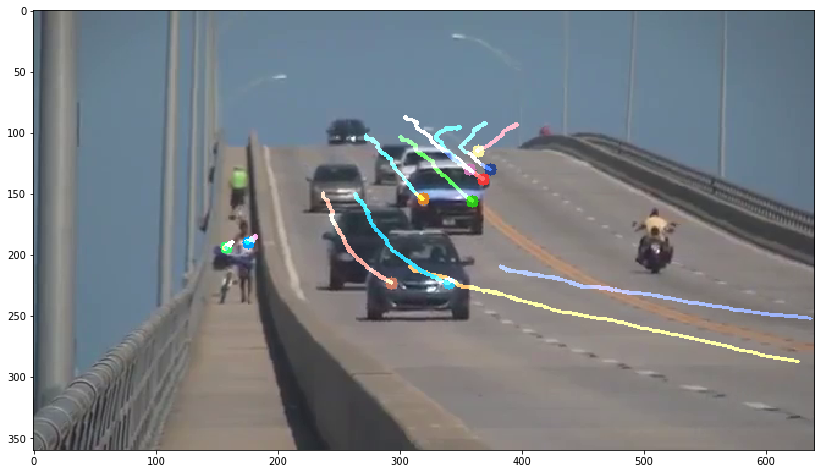

In [31]:
while True:
    ret,frame = cap.read()   
    
    if frame is None:
        break
        
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, 
                  winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)
    
    # display the image
    cv2.imshow('frame', img)
    if cv2.waitKey(1) == 27:
        break   

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cv2.destroyAllWindows()
cap.release()

### Dense Optical Flow

Lucas-Kanade method computes optical flow for a sparse feature set (in our example, corners detected using Shi-Tomasi algorithm). OpenCV provides another algorithm to find the dense optical flow. It computes the optical flow for all the points in the frame.

Below sample shows how to find the dense optical flow using above algorithm. We get a 2-channel array with optical flow vectors, $(u,v)$. We find their magnitude and direction. We color code the result for better visualization. Direction corresponds to Hue value of the image. Magnitude corresponds to Value plane. So, let's open a video first and read it's first frame, and then create an initial mask:

In [35]:
cap = cv2.VideoCapture("vtest.avi")

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)

# create mask
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

Now we start reading the frames of the video like we normally would and calculate the dense optical flow:

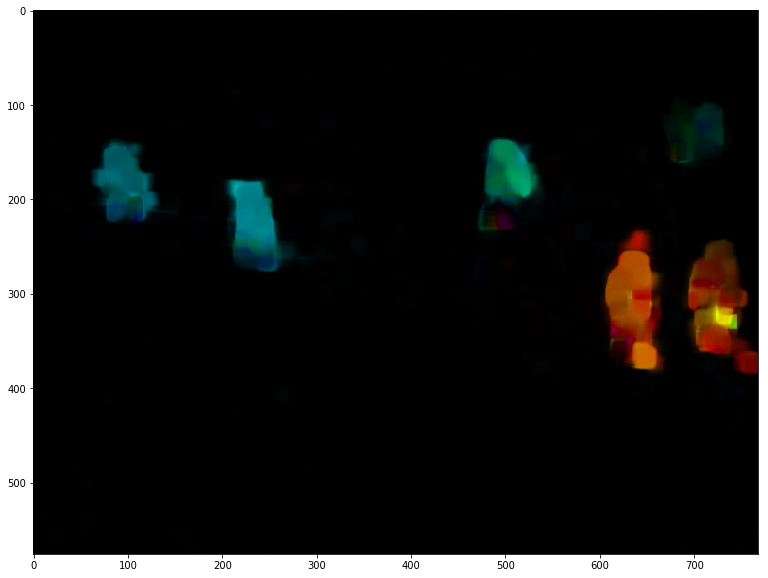

In [37]:
while True:
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    # calculate the dense optical flow
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 
           pyr_scale=0.5, levels=3,  winsize=15, 
           iterations=3,  poly_n=5, poly_sigma=1.2, flags=0)

    # this is purely for the visual effect. C
    # cartToPolar calculates the magnitude and angle of 2D vectors
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    
    # then we use magnitudes and angles as values for the Hue and Saturation channels
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert it back into RGB
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb)
    
    if cv2.waitKey(1) == 27:
        break
        
    prvs = next

cap.release()
cv2.destroyAllWindows()

## Histogram-based tracking algorithms

These are thr trackign algorithms that are based on the principle of calculating the color histogram of the region in the image where the opbject is located on frame $i$, and then trying to find a region of a similar size in the neighbouring aread on frame $i+1$ that has a similar histogram.

To do that the algorithms use something called **histogram backprojection**. OpenCV provides an inbuilt function `cv2.calcBackProject()`. Its parameters are almost same as the `cv2.calcHist()` function. One of its parameter is histogram which is histogram of the object and we have to find it. Also, the object histogram should be normalized before passing on to the backproject function. It returns the probability image.

Concider the following example. We want to take this picture, calculate the histogram of a small region (blue rectangle) and then perform the histogram backprojection to segment everything (the grass) that has a similar histogram:
![](https://clip2net.com/clip/m73955/8a9ee-clip-87kb.jpg)
Here's the code:

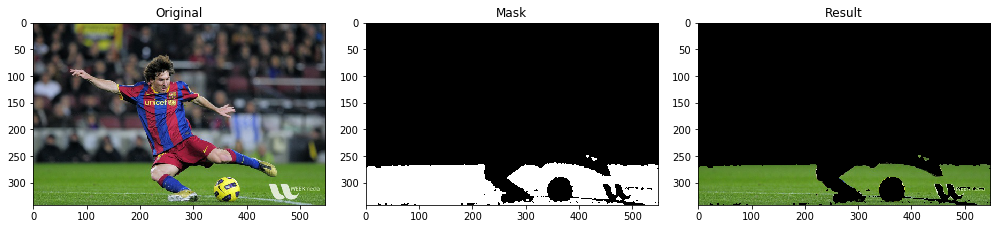

In [40]:
# load the picture
messi = cv2.imread("messi.jpg")

# extract the ROI
grass = messi[278:330, 24:174]

# convert to HSV
hsvM = cv2.cvtColor(messi, cv2.COLOR_BGR2HSV)
hsvG = cv2.cvtColor(grass, cv2.COLOR_BGR2HSV)

# calculate the histogram of the sample. Use both Hue and Saturation channels:
roihist = cv2.calcHist([hsvG],[0, 1], None, [180, 256], [0, 180, 0, 256])

# normalize histogram and apply backprojection
cv2.normalize(roihist, roihist, 0, 255, cv2.NORM_MINMAX)
dst = cv2.calcBackProject([hsvM], [0,1], roihist, [0,180,0,256], 1)

# now convolute with circular disc
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
cv2.filter2D(dst,-1,disc,dst)

# threshold and binary AND
ret, mask = cv2.threshold(dst, 50, 255, 0)
res = cv2.bitwise_and(messi, messi, mask=mask)

# display:
plt.subplots(figsize=(14, 10))
plt.subplot(131), plt.imshow(cv2.cvtColor(messi, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(132), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.subplot(133), plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB)), plt.title('Result')
plt.tight_layout()
plt.show()

### Meanshift

The intuition behind the meanshift is simple. Consider we have a set of points (it can be a pixel distribution like histogram backprojection). We are given a small window and we have to move that window to the area of maximum pixel density (or maximum number of points). It is illustrated in the simple image given below:
![](https://docs.opencv.org/3.0-beta/_images/meanshift_basics.jpg)
The initial window is shown in blue circle with the name “$C1$”. Its original center is marked in blue rectangle, named “$C1_o$”. But if we find the centroid of the points inside that window, we will get the point “$C1_r$” (marked in small blue circle) which is the real centroid of window. Obviously they don’t match. So we move our window such that circle of the new window matches with previous centroid. Again find the new centroid. Most probably, it won’t match. So we move it again, and continue the iterations such that center of window and its centroid falls on the same location (or with a small desired error). So finally what we obtain is a window with maximum pixel distribution. It is marked with green circle, named “$C2$”. As we can see in image, it has maximum number of points. The whole process is demonstrated on a static image below:
![](https://docs.opencv.org/3.0-beta/_images/meanshift_face.gif)
So we normally pass the histogram backprojected image and initial target location. When the object moves, obviously the movement is reflected in histogram backprojected image. As a result, meanshift algorithm moves our window to the new location with maximum density.

To use **meanshift** in OpenCV, first we need to setup the target, find its histogram so that we can backproject the target on each frame for calculation of meanshift. We also need to provide initial location of window. For histogram, only Hue is considered here. Also, to avoid false values due to low light, low light values are discarded using `cv2.inRange()` function.

So first, load the video and create an initial tracking windows with a custom location.

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

cap = cv2.VideoCapture('slow.mp4')

# take first frame of the video
ret,frame = cap.read()

# initial tracking window (where the object is on the first frame)
x,y,w,h = 305,185,80,65
track_window = (x,y,w,h)

Now, here we've used hard-coded values for the initial windows's location. However, this initial location can also be obtained using a Cascade Classifier (see [lecture 3](http://nbviewer.jupyter.org/urls/dl.dropboxusercontent.com/s/lc1rtnx13ig5kik/Day_03_Image_segmentation_and_object_detection.ipynb)) or colour segmentation with contour extraction (see [lecture 2](http://nbviewer.jupyter.org/urls/dl.dropboxusercontent.com/s/kivwkdkla5csin2/Day_02_Image_contours.ipynb)).

Now we will calculate the initial histogram in the starting position. We will also set up the termination criteria for the backprojection algorithm.

In [5]:
# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# apply a mask
mask = cv2.inRange(hsv_roi, (100,0,50), (170,35,250))

# calculate and normalize the histogram
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

Finally, we start reading the video frames and performing the Meanshift tracking:

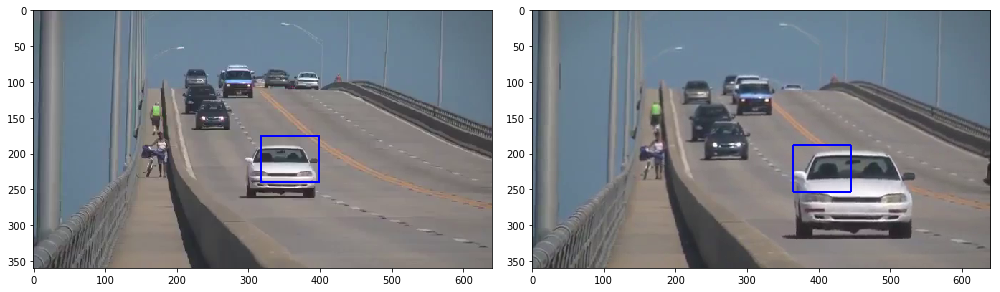

In [24]:
while True:
    ret, frame = cap.read()
    
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Draw it on image
        x,y,w,h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv2.imshow('img2',img2)
        
        if cv2.waitKey(1) == 27:
            break
    else:
        break

cv2.destroyAllWindows()
cap.release()

Now here we can see an obvious problem: the car gets closer, but the size of the track windows stays the same and it cannot be used to accurately represent the object's motion. That's why, another algorithm was introduced:

### CAMShift

As the object moves, we need to adapt the window size with size and rotation of the target. The solution is the **CAMshift** (Continuously Adaptive Meanshift) tracking algorithm. It applies Meanshift first. Once Meanshift converges, it updates the size of the window and also calculates the orientation of best fitting ellipse to it. Again it applies the meanshift with new scaled search window and previous window location. The process is continued until required accuracy is met.
![](https://docs.opencv.org/3.0-beta/_images/camshift_face.gif)

In OpenCV Camshift works almost the same as Meanshift, except it returns a rotated rectangle structure:

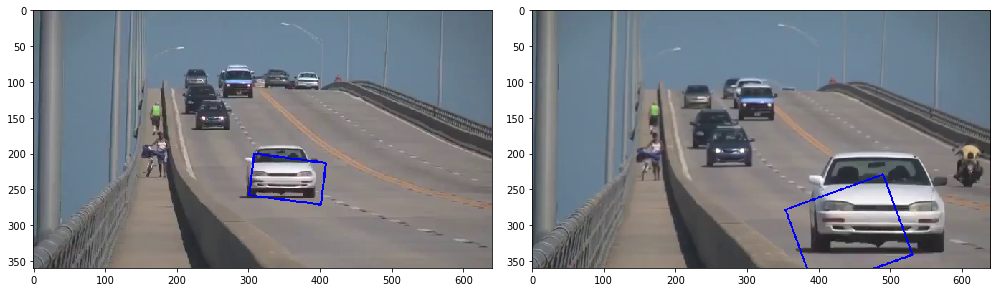

In [6]:
while True:
    ret ,frame = cap.read()
  
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)

        # Draw it on image
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame,[pts],True, 255,2)
        cv2.imshow('img2',img2)  
        
        if cv2.waitKey(1) == 27:
            break       

    else:
        break

cv2.destroyAllWindows()
cap.release()

The tracking might not work very well in most cases due to its utilization of colour histogram, though it still manages to successfully follow the white car across the video.

A more complicated example of using Camshift for tracking can me found [here](https://github.com/Xonxt/ws-onpu-2018/blob/master/Notebooks/Day_05/test_camshift.py). In this example we use the Viola-Jones cascade classifier to first detect faces on the video, then we calculate the histogram peaks to find the ideal ranges for the colour segmentation, and finally we use the Camshift algorithm to track the face.
![](https://clip2net.com/clip/m73955/e58d8-faces_track-91kb.jpg)

## Other tracking algorithms

**OpenCV 3** comes with a new tracking API that contains implementations of many single object tracking algorithms. There are 6 different trackers available in OpenCV 3.2 — BOOSTING, MIL, KCF, TLD, MEDIANFLOW, and GOTURN.

Here's the brief description of their pros and cons, so you can choose an algorithm that best suits your scenario:

### BOOSTING Tracker

This tracker is based on an online version of AdaBoost — the algorithm that the HAAR cascade based face detector uses internally

**Pros**: None. This algorithm is a decade old and works ok, but I could not find a good reason to use it especially when other advanced trackers (MIL, KCF) based on similar principles are available.

**Cons**: Tracking performance is mediocre. It does not reliably know when tracking has failed.

### MIL Tracker

This tracker is similar in idea to the BOOSTING tracker described above. But instead of considering only the current location of the object as a positive example, it looks in a small neighborhood around the current location to generate several potential positive examples. MIL stands for Multiple Instance Learning.

**Pros**: The performance is pretty good. It does not drift as much as the BOOSTING tracker and it does a reasonable job under partial occlusion. If you are using OpenCV 3.0, this might be the best tracker available to you. But if you are using a higher version, consider KCF.

**Cons**: Tracking failure is not reported reliably. Does not recover from full occlusion.

### KCF Tracker

KFC stands for Kernelized Correlation Filters. This tracker builds on the ideas presented in the previous two trackers. This tracker utilizes that fact that the multiple positive samples used in the MIL tracker have large overlapping regions.

**Pros**: Accuracy and speed are both better than MIL and it reports tracking failure better than BOOSTING and MIL. If you are using OpenCV 3.1 and above, it is recommended to use this for most applications.

**Cons**: Does not recover from full occlusion.

### TLD Tracker

TLD stands for Tracking, learning and detection. This tracker decomposes the long term tracking task into three components — (short term) tracking, learning, and detection. The tracker follows the object from frame to frame. The detector localizes all appearances that have been observed so far and corrects the tracker if necessary. The learning estimates detector’s errors and updates it to avoid these errors in the future.

**Pros**: Works the best under occlusion over multiple frames. Also, tracks best over scale changes.

**Cons**: Lots of false positives making it almost unusable.

### MEDIANFLOW Tracker

This tracker tracks the object in both forward and backward directions in time and measures the discrepancies between these two trajectories. Minimizing this ForwardBackward error enables them to reliably detect tracking failures and select reliable trajectories in video sequences.

**Pros**: Excellent tracking failure reporting. Works very well when the motion is predictable and there is no occlusion.

**Cons**: Fails under large motion.

### GOTURN tracker

Out of all the tracking algorithms in the tracker class, this is the only one based on Convolutional Neural Network (CNN). It is also the only one that uses an offline trained model, because of which it is faster that other trackers. From OpenCV documentation, we know it is “robust to viewpoint changes, lighting changes, and deformations”. But it does not handle occlusion very well.

## Using the OpenCV trackers

Here's a simple example of using one of the trackers. We chose the KCF one in this case. Other algorithms are used similarly. The scenario is the same as with the previous example: Cascade Detector detects a face and uses it as an initial tracking window. The tracker is then initialized and used in the following frames.

To create a tracker we simply need to use one of the six functions:
* `cv2.TrackerBoosting_create()`
* `cv2.TrackerMIL_create()`
* `cv2.TrackerKCF_create()`
* `cv2.TrackerTLD_create()`
* `cv2.TrackerMedianFlow_create()`
* `cv2.TrackerGOTURN_create()`

In [ ]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
face = None

tracker = cv2.TrackerKCF_create()

while True:

    ret, frame = cap.read()

    if ret == False:
        break

    if face is None:
        faces = cascade.detectMultiScale(frame, 1.05, 5)

        max_num, max_area = 0, 0

        if len(faces) == 0:
            continue
        # choose the largest rectangle as the initial tracking window
        for i in range(len(faces)):            
            (x, y, w, h) = faces[i]
            
            if (w*h) > max_area:
                max_num = i
        face = faces[max_num]
        (x,y,w,h) = face
        
        ok = tracker.init(frame, (x,y,w,h))
    else:
        ok, bbox = tracker.update(frame)
        (x,y,w,h) = bbox
        
        if ok:
            cv2.rectangle(frame, (int(x),int(y)), (int(x+w),int(y+h)), (255,0,255), 2)

    cv2.imshow("video", frame)

    key = cv2.waitKey(1)

    if key == 27:
        break
    elif key & 0xFF == ord('q'): # clear the face to detect it anew
        face = None

cap.release()
cv2.destroyAllWindows()